In [1]:
#Project 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override() 
import datetime 
from collections import OrderedDict
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

#Define 'get data' and 'get return' function 
def getDataBatch(tickers, startdate, enddate):
  def getData(ticker):
    return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
  datas = map(getData, tickers)
  return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))

def getReturns(tickers, start_dt, end_dt, freq='monthly'): 
    px_data = getDataBatch(tickers, start_dt, end_dt)
    px = px_data[['Adj Close']].reset_index().pivot(index='Date', 
                           columns='Ticker', values='Adj Close')
    if (freq=='monthly'):
        px = px.resample('M').last()
        
    ret = px.pct_change().dropna()
    
    ret.columns = tickers
    return(ret)

#Define ewma covariance(lamda is paramater)
def cov_ewma(ret_assets, lamda = 0.93):
    ret_mat = ret_assets.values
    T = len(ret_assets)
    coeff = np.zeros((T,1))
    S = ret_assets.cov()
    for i in range(1, T):
        S = lamda * S  + (1-lamda)* (ret_mat[i-1,:].reshape((-1,1)) @ ret_mat[i-1,:].reshape((1,-1)) )
        coeff[i] = (1-lamda)*lamda**(i)
    return S/np.sum(coeff)

#Define risk parity objective function
def obj_fun(W, cov_assets, risk_budget):
    var_p = np.dot(W.transpose(), np.dot(cov_assets, W))
    sigma_p = np.sqrt(var_p)
    risk_contribution = W*np.dot(cov_assets, W)/sigma_p
    risk_contribution_percent = risk_contribution/sigma_p
    return np.sum((risk_contribution_percent-risk_budget)**2)

#Define risk parity weight optimization function given risk budget
def riskparity_opt(ret_assets, risk_budget, lamda, method='ewma',Wts_min=0.0, leverage=False):
    num_assets = ret_assets.shape[1]
    if method=='ewma':
        cov_assets = cov_ewma(ret_assets, lamda)
    elif method=='ma':
        cov_assets = ret_assets.cov()
    else:
        cov_assets = cov_ewma(ret_assets, lamda)        

    w0 = 1.0 * np.ones((num_assets, 1)) / num_assets
    
    if leverage == True:
        c_ = ({'type':'eq', 'fun': lambda W: sum(W)-2. }, 
              {'type':'ineq', 'fun': lambda W: W-Wts_min}) 
    else:
        c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. }, 
              {'type':'ineq', 'fun': lambda W: W-Wts_min}) 

    return minimize(obj_fun, w0, args=(cov_assets, risk_budget), method='SLSQP', constraints=c_)

#Define Timeframe
start_dt = datetime.datetime(2007, 12, 31)
end_dt = datetime.datetime(2017, 12, 31)    

#start_dt = datetime.datetime(2008, 10, 31)
#end_dt = datetime.datetime(2018, 10, 31)

Flag_downloadData = True
if Flag_downloadData:

    Ticker_AllAsset = [ 'SPAB','SPEM','VTI']
   
    stock_data = getDataBatch(Ticker_AllAsset, start_dt, end_dt)

    price_AllAsset = stock_data.reset_index().pivot(index='Date', columns='Ticker', values='Adj Close')

    writer = pd.ExcelWriter('AssetPrice.xlsx', engine='xlsxwriter')
    price_AllAsset.to_excel(writer, sheet_name='Price',startrow=0, startcol=0, header=True, index=True)
else:
    price_AllAsset = pd.read_excel('AssetPrice.xlsx', sheet_name='Price',
                    header=0, index_col = 0)

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


In [2]:
#Get recent covariance matrix SS
ret_assets = price_AllAsset.pct_change().dropna()
ret_assets_demean = ret_assets - ret_assets.mean()
num_assets = ret_assets.shape[1]

lamda = 0.93
SS = cov_ewma(ret_assets_demean, lamda)
print(SS)

#Create a risk parity portfolio 
datestr = ret_assets.index[ret_assets.index >= '2008-03-31']
mth_previous = datestr[0]
wts = pd.DataFrame(index=datestr, columns=ret_assets.columns) #blank

ret_riskParity = pd.DataFrame(index=datestr, columns=['Risk Parity']) #blank

window = 90
Wts_min = 0.0
risk_budget = 1.0/num_assets*np.ones([1,num_assets]) 

Ticker          SPAB          SPEM           VTI
Ticker                                          
SPAB    2.503914e-06 -3.992209e-07 -8.505340e-07
SPEM   -3.992209e-07  4.509133e-05  1.360378e-05
VTI    -8.505340e-07  1.360378e-05  1.470983e-05


sharpe ratio of different strategies:
 risk_parity    [0.5708416450876974]
equal_wted     [0.4171020411018643]
dtype: object

sharpe ratio of strategies vs assets:
 risk_parity    [0.5708416450876974]
SPAB                       0.612655
SPEM                      0.0774111
VTI                        0.426852
dtype: object


<Figure size 432x288 with 0 Axes>

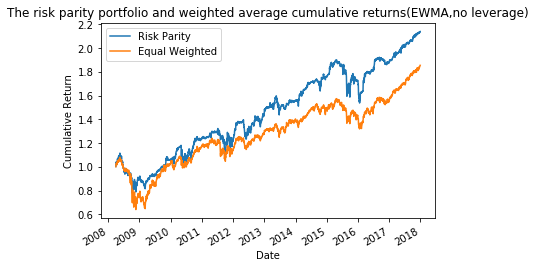

<Figure size 432x288 with 0 Axes>

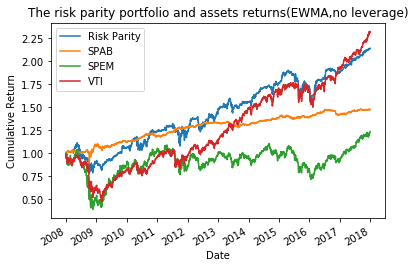

EWMA


Text(0.5,1,'The historical weights of three assets(EWMA,no leverage)')

<Figure size 432x288 with 0 Axes>

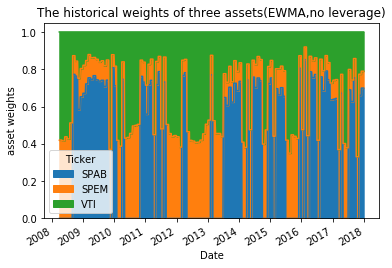

In [3]:
#%% Part1: EWMA without leverage
leverage = False
varmodel = 'ewma'

#construct risk budgeting portfolio and re-balance on monthly basis
for t in datestr:
    if t.month==mth_previous:
        wts.loc[t] = wts.iloc[wts.index.get_loc(t)-1]
    else: 
        mth_previous = t.month
        t_begin = t - timedelta(days=window)
        ret_used = ret_assets.loc[t_begin:t,:]
        wts.loc[t] = riskparity_opt(ret_used, risk_budget, lamda, varmodel, Wts_min, leverage).x

    ret_riskParity.loc[t] = np.sum(wts.loc[t] * ret_assets.loc[t])
    

wts[wts<0]=0.0

# Construct equal weighted portfolio
ret_equalwted = pd.DataFrame(np.sum(1.0*ret_assets[ret_assets.index>=datestr[0]]/num_assets, axis=1), columns=['Equal Weighted'])

# S3: Calculate performance stats
ret_cumu_assets = (ret_assets + 1).cumprod()
ret_cumu_riskP = (ret_riskParity + 1).cumprod()
ret_cumu_equalwt = (ret_equalwted + 1).cumprod()

ret_annual_assets = ret_cumu_assets.iloc[-1]**(250/len(ret_cumu_assets))-1
std_annual_assets = ret_assets.std()*np.sqrt(250)
sharpe_ratio_assets = ret_annual_assets/std_annual_assets

ret_annual_riskP = ret_cumu_riskP.iloc[-1]**(250/len(ret_cumu_riskP))-1
std_annual_riskP = ret_riskParity.std()*np.sqrt(250)
sharpe_ratio_riskP = ret_annual_riskP/std_annual_riskP

ret_annual_equalwt = ret_cumu_equalwt.iloc[-1]**(250/len(ret_cumu_equalwt))-1
std_annual_equalwt = ret_equalwted.std()*np.sqrt(250)
sharpe_ratio_equalwt = ret_annual_equalwt/std_annual_equalwt


sharpe_table = pd.Series(OrderedDict((('risk_parity', sharpe_ratio_riskP.values),
                 ('equal_wted', sharpe_ratio_equalwt.values),
                 )))
sharpe_table1 = pd.Series(OrderedDict((('risk_parity', sharpe_ratio_riskP.values),
                 ('SPAB', sharpe_ratio_assets[0]),
                 ('SPEM', sharpe_ratio_assets[1]),
                 ('VTI', sharpe_ratio_assets[2]),
                 )))
print('sharpe ratio of different strategies:\n',sharpe_table)
print('\nsharpe ratio of strategies vs assets:\n',sharpe_table1)

#plot the portfolio cumulative returns
figure_count = 1
plt.figure(figure_count)
figure_count = figure_count+1
pd.concat([ret_cumu_riskP, ret_cumu_equalwt], axis=1).plot()
plt.ylabel('Cumulative Return')
plt.title('The risk parity portfolio and weighted average cumulative returns(EWMA,no leverage)')
plt.show()

#plot the portfolio cumulative returns vs. asset returns
plt.figure(figure_count)
figure_count = figure_count+1
pd.concat([ret_cumu_riskP, ret_cumu_assets], axis=1).plot()
plt.ylabel('Cumulative Return')
plt.title('The risk parity portfolio and assets returns(EWMA,no leverage)')
plt.show()
print('EWMA')

#plot the historical weights of the assets
plt.figure(figure_count)
figure_count = figure_count + 1
wts.plot.area()
plt.ylabel('asset weights')
plt.title('The historical weights of three assets(EWMA,no leverage)')

sharpe ratio of different strategies:
 risk_parity     [0.486019999361868]
equal_wted     [0.4171020411018643]
dtype: object

sharpe ratio of strategies vs assets:
 risk_parity    [0.486019999361868]
SPAB                      0.612655
SPEM                     0.0774111
VTI                       0.426852
dtype: object


<Figure size 432x288 with 0 Axes>

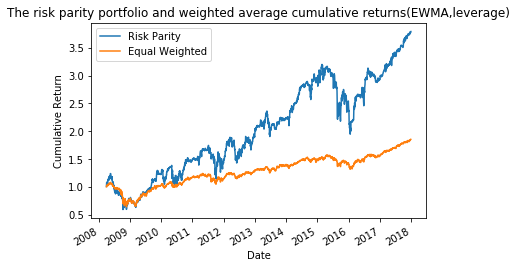

<Figure size 432x288 with 0 Axes>

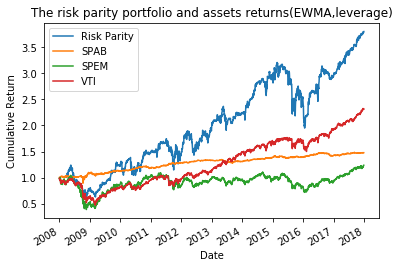

Text(0.5,1,'The historical weights of three assets(EWMA,leverage)')

<Figure size 432x288 with 0 Axes>

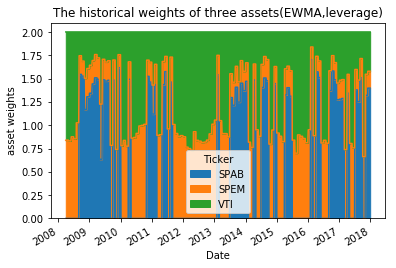

In [4]:
#%% Part 2: EWMA with leverage

leverage = True 
varmodel = 'ewma'

for t in datestr:
    if t.month==mth_previous:
        wts.loc[t] = wts.iloc[wts.index.get_loc(t)-1]
    else: 
        mth_previous = t.month
        t_begin = t - timedelta(days=window)
        ret_used = ret_assets.loc[t_begin:t,:]
        wts.loc[t] = riskparity_opt(ret_used, risk_budget, lamda, varmodel, Wts_min, leverage).x

    ret_riskParity.loc[t] = np.sum(wts.loc[t] * ret_assets.loc[t])
    

wts[wts<0]=0.0

ret_equalwted = pd.DataFrame(np.sum(1.0*ret_assets[ret_assets.index>=datestr[0]]/num_assets, axis=1), columns=['Equal Weighted'])

ret_cumu_assets = (ret_assets + 1).cumprod()
ret_cumu_riskP = (ret_riskParity + 1).cumprod()
ret_cumu_equalwt = (ret_equalwted + 1).cumprod()

ret_annual_assets = ret_cumu_assets.iloc[-1]**(250/len(ret_cumu_assets))-1
std_annual_assets = ret_assets.std()*np.sqrt(250)
sharpe_ratio_assets = ret_annual_assets/std_annual_assets

ret_annual_riskP = ret_cumu_riskP.iloc[-1]**(250/len(ret_cumu_riskP))-1
std_annual_riskP = ret_riskParity.std()*np.sqrt(250)
sharpe_ratio_riskP = ret_annual_riskP/std_annual_riskP

ret_annual_equalwt = ret_cumu_equalwt.iloc[-1]**(250/len(ret_cumu_equalwt))-1
std_annual_equalwt = ret_equalwted.std()*np.sqrt(250)
sharpe_ratio_equalwt = ret_annual_equalwt/std_annual_equalwt

sharpe_table = pd.Series(OrderedDict((('risk_parity', sharpe_ratio_riskP.values),
                 ('equal_wted', sharpe_ratio_equalwt.values),
                 )))
sharpe_table1 = pd.Series(OrderedDict((('risk_parity', sharpe_ratio_riskP.values),
                 ('SPAB', sharpe_ratio_assets[0]),
                 ('SPEM', sharpe_ratio_assets[1]),
                 ('VTI', sharpe_ratio_assets[2]),
                 )))
print('sharpe ratio of different strategies:\n',sharpe_table)
print('\nsharpe ratio of strategies vs assets:\n',sharpe_table1)


figure_count = 1
plt.figure(figure_count)
figure_count = figure_count+1
pd.concat([ret_cumu_riskP, ret_cumu_equalwt], axis=1).plot()
plt.ylabel('Cumulative Return')
plt.title('The risk parity portfolio and weighted average cumulative returns(EWMA,leverage)')
plt.show()

plt.figure(figure_count)
figure_count = figure_count+1
pd.concat([ret_cumu_riskP, ret_cumu_assets], axis=1).plot()
plt.ylabel('Cumulative Return')
plt.title('The risk parity portfolio and assets returns(EWMA,leverage)')
plt.show()

plt.figure(figure_count)
figure_count = figure_count + 1
wts.plot.area()
plt.ylabel('asset weights')
plt.title('The historical weights of three assets(EWMA,leverage)')

sharpe ratio of different strategies:
 risk_parity    [0.33660687136366024]
equal_wted      [0.4171020411018643]
dtype: object

sharpe ratio of strategies vs assets:
 risk_parity    [0.33660687136366024]
SPAB                        0.612655
SPEM                       0.0774111
VTI                         0.426852
dtype: object


<Figure size 432x288 with 0 Axes>

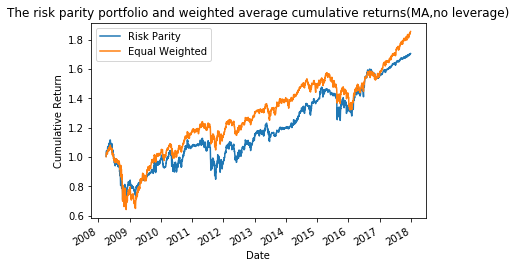

<Figure size 432x288 with 0 Axes>

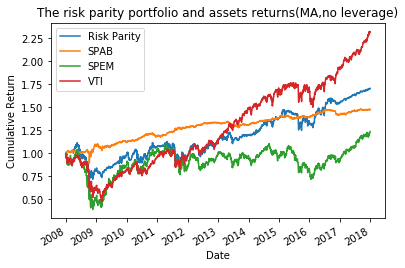

Text(0.5,1,'The historical weights of three assets(MA,no leverage)')

<Figure size 432x288 with 0 Axes>

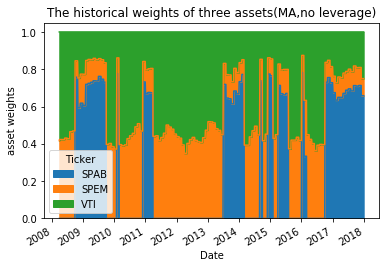

In [5]:
#%%Part 3: MA without leverage
leverage = False
varmodel = 'ma'

for t in datestr:
    if t.month==mth_previous:
        wts.loc[t] = wts.iloc[wts.index.get_loc(t)-1]
    else: 
        mth_previous = t.month
        t_begin = t - timedelta(days=window)
        ret_used = ret_assets.loc[t_begin:t,:]
        wts.loc[t] = riskparity_opt(ret_used, risk_budget, lamda, varmodel, Wts_min, leverage).x

    ret_riskParity.loc[t] = np.sum(wts.loc[t] * ret_assets.loc[t])
    

wts[wts<0]=0.0

ret_equalwted = pd.DataFrame(np.sum(1.0*ret_assets[ret_assets.index>=datestr[0]]/num_assets, axis=1), columns=['Equal Weighted'])

ret_cumu_assets = (ret_assets + 1).cumprod()
ret_cumu_riskP = (ret_riskParity + 1).cumprod()
ret_cumu_equalwt = (ret_equalwted + 1).cumprod()

ret_annual_assets = ret_cumu_assets.iloc[-1]**(250/len(ret_cumu_assets))-1
std_annual_assets = ret_assets.std()*np.sqrt(250)
sharpe_ratio_assets = ret_annual_assets/std_annual_assets

ret_annual_riskP = ret_cumu_riskP.iloc[-1]**(250/len(ret_cumu_riskP))-1
std_annual_riskP = ret_riskParity.std()*np.sqrt(250)
sharpe_ratio_riskP = ret_annual_riskP/std_annual_riskP

ret_annual_equalwt = ret_cumu_equalwt.iloc[-1]**(250/len(ret_cumu_equalwt))-1
std_annual_equalwt = ret_equalwted.std()*np.sqrt(250)
sharpe_ratio_equalwt = ret_annual_equalwt/std_annual_equalwt

sharpe_table = pd.Series(OrderedDict((('risk_parity', sharpe_ratio_riskP.values),
                 ('equal_wted', sharpe_ratio_equalwt.values),
                 )))
sharpe_table1 = pd.Series(OrderedDict((('risk_parity', sharpe_ratio_riskP.values),
                 ('SPAB', sharpe_ratio_assets[0]),
                 ('SPEM', sharpe_ratio_assets[1]),
                 ('VTI', sharpe_ratio_assets[2]),
                 )))
print('sharpe ratio of different strategies:\n',sharpe_table)
print('\nsharpe ratio of strategies vs assets:\n',sharpe_table1)


figure_count = 1
plt.figure(figure_count)
figure_count = figure_count+1
pd.concat([ret_cumu_riskP, ret_cumu_equalwt], axis=1).plot()
plt.ylabel('Cumulative Return')
plt.title('The risk parity portfolio and weighted average cumulative returns(MA,no leverage)')
plt.show()


plt.figure(figure_count)
figure_count = figure_count+1
pd.concat([ret_cumu_riskP, ret_cumu_assets], axis=1).plot()
plt.ylabel('Cumulative Return')
plt.title('The risk parity portfolio and assets returns(MA,no leverage)')
plt.show()

plt.figure(figure_count)
figure_count = figure_count + 1
wts.plot.area()
plt.ylabel('asset weights')
plt.title('The historical weights of three assets(MA,no leverage)')

sharpe ratio of different strategies:
 risk_parity    [0.25805104491949465]
equal_wted      [0.4171020411018643]
dtype: object

sharpe ratio of strategies vs assets:
 risk_parity    [0.25805104491949465]
SPAB                        0.612655
SPEM                       0.0774111
VTI                         0.426852
dtype: object


<Figure size 432x288 with 0 Axes>

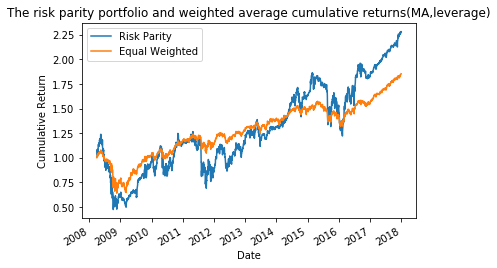

<Figure size 432x288 with 0 Axes>

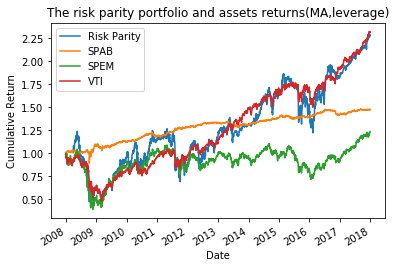

Text(0.5,1,'The historical weights of three assets(MA,leverage)')

<Figure size 432x288 with 0 Axes>

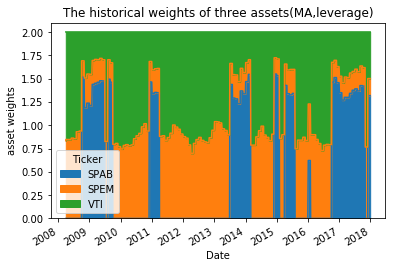

In [6]:
#%%Part 4: MA with leverage
leverage = True 
varmodel = 'ma'

for t in datestr:
    if t.month==mth_previous:
        wts.loc[t] = wts.iloc[wts.index.get_loc(t)-1]
    else: 
        mth_previous = t.month
        t_begin = t - timedelta(days=window)
        ret_used = ret_assets.loc[t_begin:t,:]
        wts.loc[t] = riskparity_opt(ret_used, risk_budget, lamda, varmodel, Wts_min, leverage).x

    ret_riskParity.loc[t] = np.sum(wts.loc[t] * ret_assets.loc[t])
    
wts[wts<0]=0.0

ret_equalwted = pd.DataFrame(np.sum(1.0*ret_assets[ret_assets.index>=datestr[0]]/num_assets, axis=1), columns=['Equal Weighted'])

ret_cumu_assets = (ret_assets + 1).cumprod()
ret_cumu_riskP = (ret_riskParity + 1).cumprod()
ret_cumu_equalwt = (ret_equalwted + 1).cumprod()

ret_annual_assets = ret_cumu_assets.iloc[-1]**(250/len(ret_cumu_assets))-1
std_annual_assets = ret_assets.std()*np.sqrt(250)
sharpe_ratio_assets = ret_annual_assets/std_annual_assets

ret_annual_riskP = ret_cumu_riskP.iloc[-1]**(250/len(ret_cumu_riskP))-1
std_annual_riskP = ret_riskParity.std()*np.sqrt(250)
sharpe_ratio_riskP = ret_annual_riskP/std_annual_riskP

ret_annual_equalwt = ret_cumu_equalwt.iloc[-1]**(250/len(ret_cumu_equalwt))-1
std_annual_equalwt = ret_equalwted.std()*np.sqrt(250)
sharpe_ratio_equalwt = ret_annual_equalwt/std_annual_equalwt

sharpe_table = pd.Series(OrderedDict((('risk_parity', sharpe_ratio_riskP.values),
                 ('equal_wted', sharpe_ratio_equalwt.values),
                 )))
sharpe_table1 = pd.Series(OrderedDict((('risk_parity', sharpe_ratio_riskP.values),
                 ('SPAB', sharpe_ratio_assets[0]),
                 ('SPEM', sharpe_ratio_assets[1]),
                 ('VTI', sharpe_ratio_assets[2]),
                 )))
print('sharpe ratio of different strategies:\n',sharpe_table)
print('\nsharpe ratio of strategies vs assets:\n',sharpe_table1)


figure_count = 1
plt.figure(figure_count)
figure_count = figure_count+1
pd.concat([ret_cumu_riskP, ret_cumu_equalwt], axis=1).plot()
plt.ylabel('Cumulative Return')
plt.title('The risk parity portfolio and weighted average cumulative returns(MA,leverage)')
plt.show()

plt.figure(figure_count)
figure_count = figure_count+1
pd.concat([ret_cumu_riskP, ret_cumu_assets], axis=1).plot()
plt.ylabel('Cumulative Return')
plt.title('The risk parity portfolio and assets returns(MA,leverage)')
plt.show()

plt.figure(figure_count)
figure_count = figure_count + 1
wts.plot.area()
plt.ylabel('asset weights')
plt.title('The historical weights of three assets(MA,leverage)')